In [15]:
using MatrixNetworks
using Distributions
using Clustering
using BenchmarkTools, Compat
using DelimitedFiles
using SparseArrays
using LinearAlgebra
using EllipsoidalGraphEmbedding
using Random
using Arpack
using Plots, LaTeXStrings

using Graphs
using GraphPlot

using IterTools
using Statistics
using Measures

using CairoMakie
using GLMakie
using GraphMakie: graphplot
using GraphMakie: graphplot!

### LFR toy benchmark

 ------- Acc Projected Power Iteration -------
The iteration has become stationary after 67 iterations
  0.170998 seconds (1.91 k allocations: 93.208 MiB)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 10
Number of updates: 6
Number of communities: 4
Modularity: 0.5878079853351543
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.47010702852203073, 0.3454115282097107, 0.18448144236587777, 5.071045886548493e-10, 1.4840212975564097e-10]
 -------------------------------------------- 
  1.516873 seconds (363.57 k allocations: 314.754 MiB)
NMI with ground truth: 0.9999999999999997


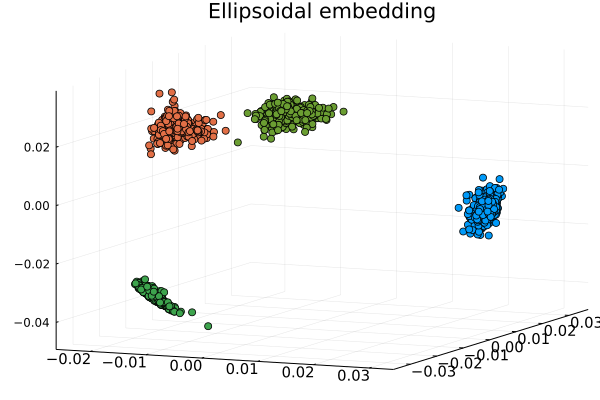

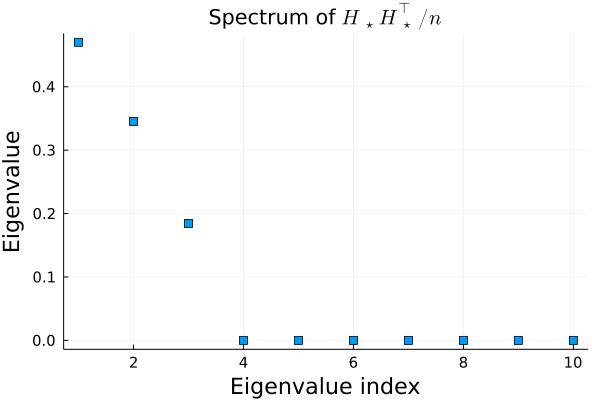

In [16]:
set = "toy_1"#"toy_2"

com_data = readdlm("Data/LFR_data/"*set*"_communities.txt");
adj = readdlm("Data/LFR_data/"*set*"_edgeList.txt");
adj = adj .+ 1 #indices start from 1

# converting to int array
community_true = com_data;
community_true = convert(Array{Int64},community_true);

N = length(community_true);

# construct adjacency matrix
n_edge2 = size(adj)[1];
A = sparse(adj[:,1],adj[:,2],vec(ones(Int64,n_edge2,1)),N,N)
A = A + A'
# largest connected component
A,_ = largest_component(A);
adj = 0; # clear memory

# nb iterations projected power method
n_it_PPM = 30000;

# relative objective variation
t = 1e-8;

# number of columns of initial guess
d0 = 10

# number of centroids thrown in embedding
n_clusters = 100;

# nb of times vector partition is repeated
n_it_vec_part = 10;

# nb updates vec part
n_updates = 50; # by default

# shape of embedding
shape = "Ellipsoidal"; #shape = "Spherical"

# Initialization
community = zeros(Int64,N,1);
x_embed,community,sigma =  @time sphere_embed_cluster(A, n_it_PPM, t, n_clusters, n_it_vec_part, n_updates, shape, d0);

# normalized multual information
nmi = mutualinfo(community_true,community)
println("NMI with ground truth: ", nmi)
# beware run twice to get timings without compilation time

p1 = Plots.plot(x_embed[1,:],x_embed[2,:],x_embed[3,:],seriestype=:scatter, color = community_true, legend = false,xtickfontsize=10,ytickfontsize=10, xguidefontsize=15, yguidefontsize=15,title= "Ellipsoidal embedding")
savefig("figures/LFR_"*set*"_embedding.pdf")
display(p1)

p2 = Plots.plot(1:length(sigma),sigma.^2/N,seriestype=:scatter, legend = false,yticks = 0:0.1:0.5,xtickfontsize=10,ytickfontsize=10, xguidefontsize=15, yguidefontsize=15, marker=:square)
Plots.xlabel!("Eigenvalue index")
Plots.ylabel!("Eigenvalue")
Plots.title!(L"Spectrum of $H_\star H_\star^\top /n$")
savefig("figures/LFR_"*set*"_spectrum.pdf")
display(p2)

### Power EU graph: ellipsoidal embedding

 ------- Acc Projected Power Iteration -------
The iteration has become stationary after 212 iterations
  9.334940 seconds (335.98 k allocations: 1.952 GiB, 58.33% gc time, 4.60% compilation time)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 50
Number of updates: 13
Number of communities: 34
Modularity: 0.9082232920320839
 -------------------------------------------- 
The first 5 squared singular values divided by N : 
[0.5221210457349927, 0.34923545443171206, 0.11776939590278727, 0.006674861204858615, 0.0018144981600353037]
 -------------------------------------------- 
 15.121306 seconds (1.19 M allocations: 2.676 GiB, 37.57% gc time, 2.84% compilation time)


┌ Warning: Indices Base.OneTo(2000) of attribute `seriescolor` does not match data indices 1:2712.
└ @ Plots /Users/mfanuel/.julia/packages/Plots/PomtQ/src/utils.jl:132
┌ Warning: Indices Base.OneTo(2000) of attribute `linecolor` does not match data indices 1:2712.
└ @ Plots /Users/mfanuel/.julia/packages/Plots/PomtQ/src/utils.jl:132
┌ Warning: Indices Base.OneTo(2000) of attribute `fillcolor` does not match data indices 1:2712.
└ @ Plots /Users/mfanuel/.julia/packages/Plots/PomtQ/src/utils.jl:132
┌ Warning: Indices Base.OneTo(2000) of attribute `markercolor` does not match data indices 1:2712.
└ @ Plots /Users/mfanuel/.julia/packages/Plots/PomtQ/src/utils.jl:132


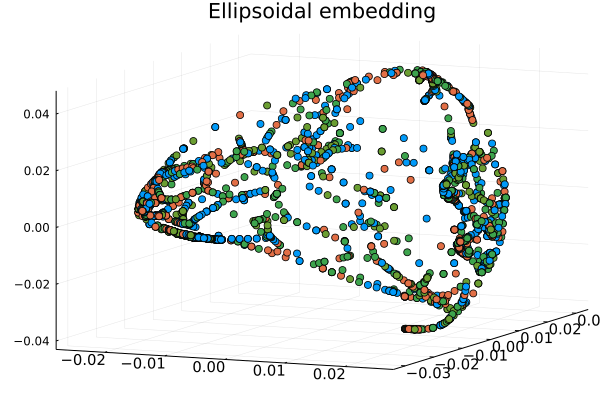

┌ Warning: Indices Base.OneTo(2000) of attribute `seriescolor` does not match data indices 1:2712.
└ @ Plots /Users/mfanuel/.julia/packages/Plots/PomtQ/src/utils.jl:132
┌ Warning: Indices Base.OneTo(2000) of attribute `linecolor` does not match data indices 1:2712.
└ @ Plots /Users/mfanuel/.julia/packages/Plots/PomtQ/src/utils.jl:132
┌ Warning: Indices Base.OneTo(2000) of attribute `fillcolor` does not match data indices 1:2712.
└ @ Plots /Users/mfanuel/.julia/packages/Plots/PomtQ/src/utils.jl:132
┌ Warning: Indices Base.OneTo(2000) of attribute `markercolor` does not match data indices 1:2712.
└ @ Plots /Users/mfanuel/.julia/packages/Plots/PomtQ/src/utils.jl:132


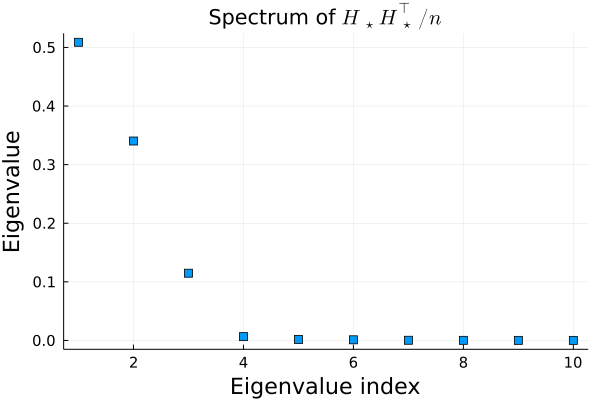

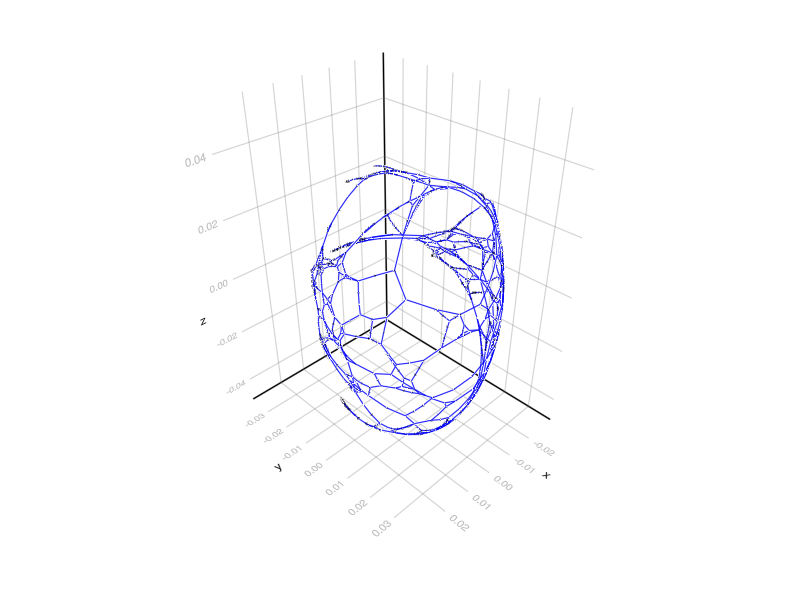

In [17]:
# Loading data
m = readdlm("Data/PowerEU/ElistPowerEU.txt");
dim = size(m,1);

M_int = zeros(Int64,dim,2);
for i =1:dim
	for j=1:2
		M_int[i,j] = Int64(m[i,j]);
	end
end

N = maximum([maximum(M_int[:,1]),maximum(M_int[:,2])]);

A0 =spzeros(N,N);
A0 = sparse(M_int[:,1],M_int[:,2],vec(ones(Int64,dim,1)),N,N);
A0 = A0+A0';
A,p = largest_component(A0);
A0=0;p=0;m =0;

# nb iterations projected power method
n_it_PPM = 30000;

# relative objective variation
t = 1e-8;

# number of columns of initial guess
d0 = 50;

# number of centroids thrown in embedding
n_clusters = 100;

# nb of times vector partition is repeated
n_it_vec_part = 10;

# nb updates vec part
n_updates = 50;

# shape of embedding
shape = "Ellipsoidal"; #shape = "Spherical"

# Initialization
community = zeros(Int64,N,1);
x_embed,community,singular =  @time sphere_embed_cluster(A, n_it_PPM, t, n_clusters, n_it_vec_part, n_updates, shape, d0)
# beware run twice to get timings without compilation time


p1 = Plots.plot(x_embed[1,:],x_embed[2,:],x_embed[3,:],seriestype=:scatter, color = community_true, legend = false,xtickfontsize=10,ytickfontsize=10, xguidefontsize=15, yguidefontsize=15,title= "Ellipsoidal embedding")
savefig("figures/PowerEU_ellipsoidal_embedding.pdf")
display(p1)

p2 = Plots.plot(1:10,singular[1:10].^2/N,seriestype=:scatter, legend = false,yticks = 0:0.1:0.5,xtickfontsize=10,ytickfontsize=10, xguidefontsize=15, yguidefontsize=15, marker=:square)
Plots.xlabel!("Eigenvalue index")
Plots.ylabel!("Eigenvalue")
Plots.title!(L"Spectrum of $H_\star H_\star^\top /n$")
savefig("figures/PowerEU_ellipsoidal_spectrum.pdf")
display(p2)

g = Graph(A)
x = x_embed'
function mylayout(g)
    # create iterator going over x-coord and y-coord 
    return Point.(zip(x[:, 1], x[:, 2],x[:, 3]))
end

f, ax, p = graphplot(g; layout=mylayout,edge_color=:blue,node_size=1,edge_width=1)    
f

### Power EU graph: spectral embedding

┌ Warning: Indices Base.OneTo(2000) of attribute `seriescolor` does not match data indices 1:2712.
└ @ Plots /Users/mfanuel/.julia/packages/Plots/PomtQ/src/utils.jl:132
┌ Warning: Indices Base.OneTo(2000) of attribute `linecolor` does not match data indices 1:2712.
└ @ Plots /Users/mfanuel/.julia/packages/Plots/PomtQ/src/utils.jl:132
┌ Warning: Indices Base.OneTo(2000) of attribute `fillcolor` does not match data indices 1:2712.
└ @ Plots /Users/mfanuel/.julia/packages/Plots/PomtQ/src/utils.jl:132
┌ Warning: Indices Base.OneTo(2000) of attribute `markercolor` does not match data indices 1:2712.
└ @ Plots /Users/mfanuel/.julia/packages/Plots/PomtQ/src/utils.jl:132


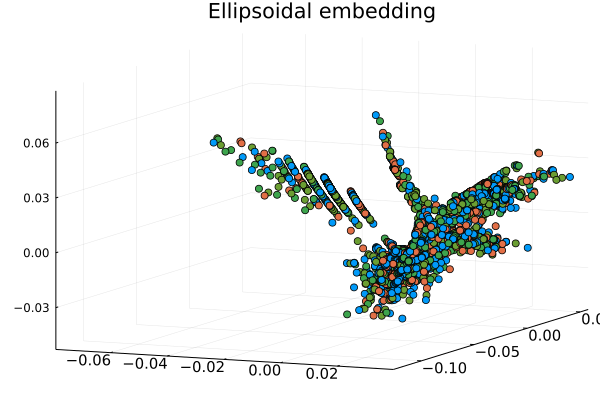

┌ Warning: Indices Base.OneTo(2000) of attribute `seriescolor` does not match data indices 1:2712.
└ @ Plots /Users/mfanuel/.julia/packages/Plots/PomtQ/src/utils.jl:132
┌ Warning: Indices Base.OneTo(2000) of attribute `linecolor` does not match data indices 1:2712.
└ @ Plots /Users/mfanuel/.julia/packages/Plots/PomtQ/src/utils.jl:132
┌ Warning: Indices Base.OneTo(2000) of attribute `fillcolor` does not match data indices 1:2712.
└ @ Plots /Users/mfanuel/.julia/packages/Plots/PomtQ/src/utils.jl:132
┌ Warning: Indices Base.OneTo(2000) of attribute `markercolor` does not match data indices 1:2712.
└ @ Plots /Users/mfanuel/.julia/packages/Plots/PomtQ/src/utils.jl:132


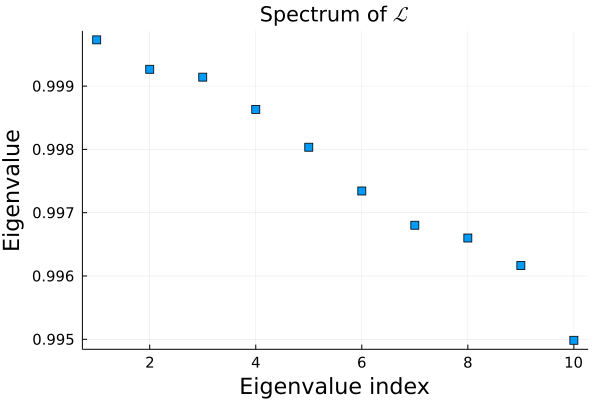

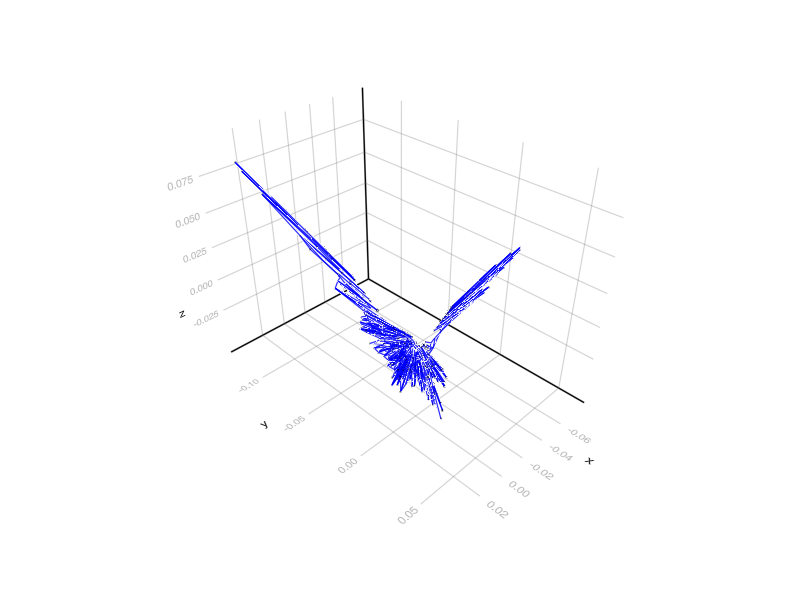

In [18]:
d = sum(A,dims=2)
D = Diagonal(1 ./ vec(sqrt.(d)))
p = sqrt.(d/sum(d))

L = D * A * D - p * p'

λ, V = eigs(L, nev = 10, which=:LR)
x_embed_spectral = (V[:,1:3])'

p1 = Plots.plot(x_embed_spectral[1,:],x_embed_spectral[2,:],x_embed_spectral[3,:],seriestype=:scatter, color = community_true, legend = false,xtickfontsize=10,ytickfontsize=10, xguidefontsize=15, yguidefontsize=15,title= "Ellipsoidal embedding")
savefig("figures/PowerEU_Laplacian_embedding.pdf")
display(p1)

p2 = Plots.plot(1:10,λ, legend = false ,seriestype=:scatter,xtickfontsize=10,ytickfontsize=10, xguidefontsize=15, yguidefontsize=15, marker=:square)
Plots.xlabel!("Eigenvalue index")
Plots.ylabel!("Eigenvalue")
Plots.title!(L"Spectrum of $\mathcal{L}$")
savefig("figures/PowerEU_Laplacian_spectrum.pdf")
display(p2)

g = Graph(A)
x = x_embed_spectral'
function mylayout(g)
    # create iterator going over x-coord and y-coord 
    return Point.(zip(x[:, 1], x[:, 2],x[:, 3]))
end

f, ax, p = graphplot(g; layout=mylayout,edge_color=:blue,node_size=1,edge_width=1)    
f

### Toy example Fig 1

 ------- Acc Projected Power Iteration -------
The iteration has become stationary after 43 iterations
  0.000835 seconds (796 allocations: 130.312 KiB)
 -------------- Clustering ------- 
dimension of embedding used for clustering: 2
Number of updates: 1
Number of communities: 3
Modularity: 0.4666666666666666
 -------------------------------------------- 
The squared singular values divided by N : 
[0.5002692612488896, 0.4997307387511103]
 -------------------------------------------- 
  0.011692 seconds (15.07 k allocations: 1.809 MiB)


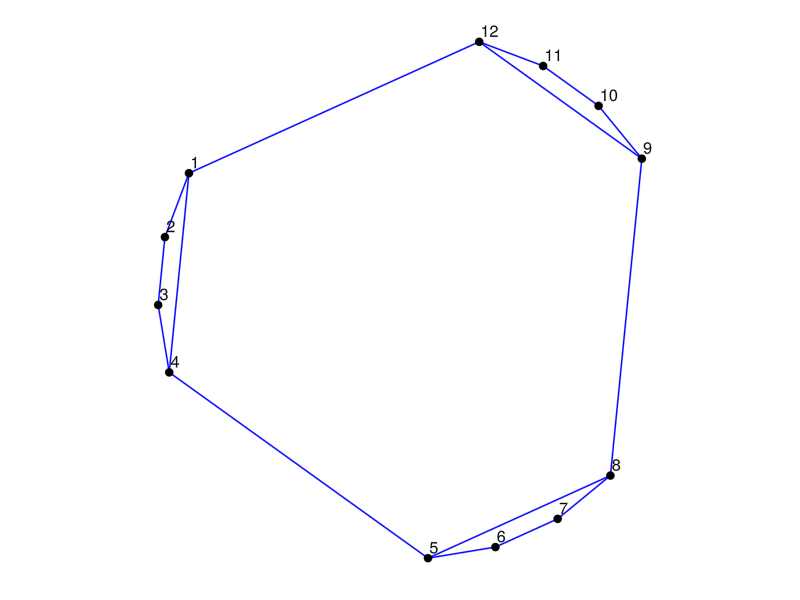

In [19]:
A = zeros(Int64,12,12)
A[1,2] = 1
A[1,4] = 1
A[2,3] = 1
A[3,4] = 1

A[5,6] = 1
A[5,8] = 1
A[6,7] = 1
A[7,8] = 1

A[9,10] = 1
A[9,12] = 1
A[10,11] = 1
A[11,12] = 1

A[4,5] = 1
A[8,9] = 1
A[12,1] = 1

A = sparse(A + A')

N = size(A,1)
n_it_PPM = 1000
n_clusters = 10
n_it_vec_part = 100
n_updates = 100
shape = "Spherical"
d0 = 2

community = zeros(Int64,N,1);
x_embed,community,sigma =  @time sphere_embed_cluster(A, n_it_PPM, t, n_clusters, n_it_vec_part, n_updates, shape, d0)

g = Graph(A)
x = x_embed'
function mylayout(g)
    # create iterator going over x-coord and y-coord 
    return Point.(zip(x[:, 1], x[:, 2]))
end

#f, ax, p = graphplot(g)
lab = vec(["1" "2" "3" "4" "5" "6" "7" "8" "9" "10" "11" "12"])
f, ax, p = graphplot(g; layout=mylayout,nlabels=lab,nlabels_distance=2,edge_color=:blue)    

hidedecorations!(ax); hidespines!(ax)
ax.aspect = DataAspect()
f